# PREDICTING RSA CLUSTER LABELS

This notebook uses ANN and KNN to predict RSA cluster labels. In here, we try 50 models from 10 different seeds and chose the best according to validation accuracy and loss. Moreover, we perform 10 repeat 10-fold cross validation to ensure the model works well across a range of different training data folds.

## IMPORTING NECESSATY PACKAGES

In [1]:
from fragsys_ml import *

2023-05-02 16:42:15.531802: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## READING INPUT DATA

In [2]:
main_dir = "."
results_dir = os.path.join(main_dir, "results/new")

rsa_cluster_dict = load_pickle(os.path.join(results_dir, "rsa_cluster_dict.pkl"))
cluster_membership = load_pickle(os.path.join(results_dir, "rsa_cluster_membership.pkl"))
rsa_profs = load_pickle(os.path.join(results_dir, "rsa_profs.pkl"))
ud_mat = pd.read_pickle(os.path.join(results_dir, "UD_df.pkl"))

## CREATING FEATURE DATAFRAME

In [3]:
max_len = max([len(v) for v in rsa_profs.values()])
bs_vectors = []
bs_vectors_dict = {}
for bs_id, rsa_sig in rsa_profs.items():
    rsa_sig_len = len(rsa_sig)
    rsa_range_prop = [0 for i in range(10)] # now let us change to 10
    for rsa in rsa_sig:
        prop_i = int(rsa/10) # 10 RSA BINS: b1 = [0,10), b2 = [10, 20), ... b10 = [90, MAX)
        if prop_i > 9: # if greater than 100, put in 10th bin
            prop_i = 9
        #print(prop_i)
        rsa_range_prop[prop_i] += 1
    rsa_range_prop = [round(i/rsa_sig_len, 3) for i in rsa_range_prop]
    rsa_range_prop.insert(0, rsa_sig_len/max_len) # ADDING BINDING SITE SIZE RELATIVE TO MAX SITE SIZE (IN THIS CASE 40)
    bs_vectors.append(rsa_range_prop)
    bs_vectors_dict[bs_id] = rsa_range_prop
    
vector_df = pd.DataFrame(bs_vectors, index = list(rsa_profs.keys())) # obtaining RSA vectors, which are the 11-element features used for the machine learning

In [4]:
vector_df.head(3)

,0,1,2,3,4,5,6,7,8,9,10
H0Y4R8_0_BS0,0.150,0.000,0.000,0.167,0.167,0.333,0.000,0.167,0.167,0.0,0.0
O43809_0_BS0,0.600,0.375,0.250,0.083,0.167,0.042,0.042,0.000,0.042,0.0,0.0
O43809_0_BS1,0.325,0.231,0.077,0.231,0.077,0.077,0.077,0.077,0.154,0.0,0.0


In [5]:
vector_df.shape

(293, 11)

In [13]:
vector_df.to_pickle(os.path.join(results_dir, "rsa_vectors.pkl"))

In [6]:
label_df = pd.DataFrame.from_dict(rsa_cluster_dict, orient = "index", columns = ["label"])

In [7]:
round(label_df.label.value_counts().sort_index()/len(label_df),2)

0    0.16
1    0.43
2    0.31
3    0.10
Name: label, dtype: float64

In [8]:
label_df.head(3)

,label
O43809_0_BS0,0
Q5T0W9_0_BS2,0
Q5T0W9_0_BS3,0


In [9]:
label_df.shape

(293, 1)

## CREATE MODEL

In [20]:
X = vector_df.sort_index() # here, X is still a dataframe. Thus, we maintain binding site IDs
y = label_df.sort_index()    # here, y is still a list

#### DATA SPLIT IN MODEL (10/11) (USED FOR TRAINING) AND BLIND (USED FOR FINAL TESTING) (1/11) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [21]:
X_model, X_blind, y_model, y_blind = train_test_split(X, y, test_size = 0.091, random_state = 12345, shuffle = True, stratify = y) ### X_blind and y_blind will be the blind test at the end

In [22]:
y_model.head(3)

,label
P47811_0_BS1,1
P0DTD1_0_BS23,1
Q96HY7_0_BS0,1


#### CLASSES ARE IMBALANCED DUE TO OUR TRAINING DATASET, BUT BOTH TRAINING AND TEST DATA HAVE THE SAME PROPORTION FOR EACH CLASS

In [23]:
print(len(X_model))
print(len(X_blind))
print(len(y_model))
print(len(y_blind))
for el in [0,1,2,3]:
    print(el, round(y_model.label.tolist().count(el)/len(y_model),2))
for el in [0,1,2,3]:
    print(el, round(y_blind.label.tolist().count(el)/len(y_blind),2))

266
27
266
27
0 0.16
1 0.43
2 0.31
3 0.1
0 0.15
1 0.44
2 0.3
3 0.11


#### CALLBACK TO GET BEST MODEL DURING TRAINING

In [24]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 0.01, patience = 100, verbose = 1, mode = 'max', restore_best_weights = True)

#### OBTAINING CLASS WEIGHTS TO MINIMISE EFFECT OF CLASS IMBALANCE IN TRAINING DATASET

In [25]:
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_model.label.tolist()),
                                                 y = np.array(y_model.label))
class_weights_dict = {i: class_weights[i] for i in np.unique(y_model)}

#### THE WEIGHT FOR EACH CLASS IS INVERSELY PROPORTIONAL TO THEIR FREQUENCY IN THE DATA SET

In [26]:
for k, v in class_weights_dict.items():
    print(k, round(v, 2))

0 1.58
1 0.58
2 0.8
3 2.56


#### DATA SPLIT IN MODEL_TRAIN (0.8) (USED FOR MODEL TRAINING) AND MODEL_VAL (0.2) (USED FOR MODEL VALIDATION DURING TRAINING) STRATIFYING BY CLUSTER LABEL, SO THEY ARE BALANCED

In [27]:
X_model_train, X_model_val, y_model_train, y_model_val = train_test_split(X_model, y_model, test_size = 0.2, random_state = 12345, shuffle = True, stratify = y_model)

In [28]:
len(set(X_model_train.index.tolist()).intersection(set(y_model_train.index.tolist())))/len(y_model_train)

1.0

In [29]:
len(set(X_model_val.index.tolist()).intersection(set(y_model_val.index.tolist())))/len(y_model_val)

1.0

#### TRAINING AND VALIDATION DATA HAVE THE SAME PROPORTION FOR EACH CLASS

In [30]:
print(len(X_model_train))
print(len(X_model_val))
print(len(y_model_train))
print(len(y_model_val))
for el in [0,1,2,3]:
    print(el, round(y_model_train.label.tolist().count(el)/len(y_model_train),2))
for el in [0,1,2,3]:
    print(el, round(y_model_val.label.tolist().count(el)/len(y_model_val),2))

212
54
212
54
0 0.16
1 0.43
2 0.31
3 0.1
0 0.17
1 0.43
2 0.31
3 0.09


# TRAINING

In [31]:
random.seed(1)

In [35]:
seeds = [random.randint(1, 100000) for i in range(10)] # [90015, 88091, 30338, 35897, 58161, 3551, 97160, 85734, 92233, 99814]

In [36]:
print(seeds) #[17612, 74607, 8272, 33433, 15456, 64938, 99741, 58916, 61899, 85406]

[49757, 27520, 12303, 63945, 3716, 51094, 56724, 79619, 99914, 277]


In [34]:
#seeds = [90015, 88091, 30338, 35897, 58161, 3551, 97160, 85734, 92233, 99814]

In [37]:
initializer = tf.keras.initializers.GlorotUniform(seed = 3551)

In [38]:
X_model_train.head(3)

,0,1,2,3,4,5,6,7,8,9,10
P0DTD1_2_BS0,0.550,0.136,0.227,0.045,0.182,0.091,0.000,0.136,0.045,0.091,0.045
Q6PJP8_0_BS9,0.175,0.000,0.000,0.429,0.143,0.000,0.000,0.286,0.143,0.000,0.000
Q8IU60_0_BS0,0.300,0.333,0.000,0.167,0.250,0.083,0.083,0.000,0.000,0.000,0.083


### USING 10 DIFFERENT SEEDS, AND 50 MODELS WITHIN EACH SEED TO SELECT BEST MODEL

In [41]:
wd = "./results/ANN_results/diff_seeds_NEW"
os.mkdir(wd)
for seed in seeds:
    print("STARTING SEED {}".format(seed))
    seed_dir = os.path.join(wd, str(seed))
    mods_dir = os.path.join(seed_dir, "models")
    hist_dir = os.path.join(seed_dir, "hists")
    os.mkdir(seed_dir)
    os.mkdir(mods_dir)
    os.mkdir(hist_dir)
    
    initializer_seed = tf.keras.initializers.GlorotUniform(seed = seed)
    for i in range(50):
        print(i+1)
        
        model_i = Sequential([
            Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer_seed), # THIS IS THE MODEL
            Dense(units = 4, activation = "softmax", kernel_initializer = initializer_seed)
        ])
        
        model_i.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"]) # COMPILE MODEL
        
        hist_i = model_i.fit(
            x = X_model_train, y = y_model_train, batch_size = 32,
            callbacks = [callback], validation_data = (X_model_val, y_model_val),
            epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict # TRAIN MODEL
        )
        final_epoch = callback.stopped_epoch-100
        if final_epoch == -100:
            final_epoch = 299
        final_acc = round(hist_i.history["val_accuracy"][final_epoch],2)
        
        model_i.save(os.path.join(mods_dir, "{}_{}_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch, round(final_acc, 2)))) # SAVING MODEL
        
        pd.DataFrame(hist_i.history).to_csv(os.path.join(hist_dir, "{}_{}_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch, round(final_acc, 2))), index = False) # SAVING TRAINING DF

STARTING SEED 49757
1
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
2
Restoring model weights from the end of the best epoch: 63.
Epoch 163: early stopping
3
Restoring model weights from the end of the best epoch: 147.
Epoch 247: early stopping
4
Restoring model weights from the end of the best epoch: 60.
Epoch 160: early stopping
5
Restoring model weights from the end of the best epoch: 58.
Epoch 158: early stopping
6
Restoring model weights from the end of the best epoch: 120.
Epoch 220: early stopping
7
Restoring model weights from the end of the best epoch: 60.
Epoch 160: early stopping
8
Restoring model weights from the end of the best epoch: 56.
Epoch 156: early stopping
9
Restoring model weights from the end of the best epoch: 57.
Epoch 157: early stopping
10
Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
11
Restoring model weights from the end of the best epoch: 52.
Epoch 152: early stopping
12
Resto

## REPEATED STRATIFIED K-FOLD CROSS-VALIDATION

In [42]:
rskf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 10, random_state = 312) #sets are one after other. 0-10, is one 10-fold CV, 10-20, and so on

In [43]:
accs_pred_ANN = [] # prediction accuracies by ANN
accs_pred_KNN = [] # prediction accuracies by KNN

accs_rand = [] # prediction accuracies at random (randomly assigning a cluster label p=0.25 each)

accs_pred_ANN_rand = [] # prediction accuracies of randomly trained ANN
accs_pred_KNN_rand = [] # prediction accuracies of randomly trained KNN

knn = KNeighborsClassifier(n_neighbors=3) # starting KNN classifier

ann_good_preds = [] # predictions by ANN
ann_good_preds_round = [] # rounded predictions by ANN
ann_real_vals = [] # real labels
ann_rand_preds = [] # predictions by randomly trained ANN
ann_rand_preds_round = [] # rounded predictions of randomly trained ANN
#ann_


cv_dir = "./results/ANN_results/cv_NEW"
cv_good_dir = os.path.join(cv_dir, "good")
cv_rand_dir = os.path.join(cv_dir, "rand")

for i, (train_idx, val_idx) in enumerate(rskf.split(X_model, y_model)):
    
    seed = 3551
    seed1 = random.randint(1, 1000000000)
    seed2 = random.randint(1, 1000000000)
    #seed1 = 426359796
    #seed2 = 44036644
    print(seed1, seed2)
    
    bs_ids_train = X_model.index[train_idx].tolist() # THESE IDS WILL SUBSET BOTH DATASETS IN THE SAME WAY (INPUT FOR KNN AND INPUT FOR ANN)
    bs_ids_val = X_model.index[val_idx].tolist() # THESE IDS WILL SUBSET BOTH DATASETS IN THE SAME WAY (INPUT FOR KNN AND INPUT FOR ANN)
    
    X_train_ANN = X_model.loc[bs_ids_train, :]
    y_train_ANN = y_model.loc[bs_ids_train, :]
    
    X_train_ANN_rand = randomise(X_train_ANN, seed1)     # THIS WILL BE USED TO TRAIN ANN WITH RANDOMLY SHUFFLED TRAINING DATA
    y_train_ANN_rand = randomise(y_train_ANN, seed2)     # THIS WILL BE USED TO TRAIN ANN WITH RANDOMLY SHUFFLED TRAINING DATA
    
    X_val_ANN = X_model.loc[bs_ids_val, :]
    y_val_ANN = y_model.loc[bs_ids_val, :]
    
    X_train_KNN = ud_mat.loc[bs_ids_train, bs_ids_train]
    y_train_KNN = y_model.loc[bs_ids_train, :]
    
    X_train_KNN_rand = randomise(X_train_KNN, seed1)     # THIS WILL BE USED TO TRAIN KNN WITH RANDOMLY SHUFFLED TRAINING DATA
    y_train_KNN_rand = randomise(y_train_KNN, seed2)     # THIS WILL BE USED TO TRAIN KNN WITH RANDOMLY SHUFFLED TRAINING DATA
    
    X_val_KNN = ud_mat.loc[bs_ids_val, bs_ids_train]
    y_val_KNN = y_model.loc[bs_ids_val, :]
    
    #break
    
    ### PREDICTING WITH ANN ### well trained model
    
    X_model_train_ANN, X_model_val_ANN, y_model_train_ANN, y_model_val_ANN = train_test_split(
        X_train_ANN, y_train_ANN, test_size = 0.2, random_state = 12345,
        shuffle = True, stratify = y_train_ANN
    )
    
    class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_ANN.label.tolist()),
                                                 y = np.array(y_train_ANN.label))
    
    class_weights_dict = {i: class_weights[i] for i in np.unique(y_train_ANN.label.tolist())}
    
    cv_model = Sequential([
        Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer),
        Dense(units = 4, activation = "softmax", kernel_initializer = initializer)
    ])
    
    cv_model.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    
    hist_cv_model = cv_model.fit(
        x = X_model_train_ANN, y = y_model_train_ANN, batch_size = 32,
        callbacks=[callback], validation_data = (X_model_val_ANN, y_model_val_ANN),
        epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict
    )
    
    predictions = cv_model.predict(x = X_val_ANN, batch_size = 32, verbose = 0)
    rounded_predictions = np.argmax(predictions, axis = -1)
    CalculatedAccuracy = sum(rounded_predictions == y_val_ANN.label.tolist())/len(rounded_predictions)
    accs_pred_ANN.append(CalculatedAccuracy)
    ann_good_preds.append(predictions)
    ann_good_preds_round.append(rounded_predictions)
    ann_real_vals.append(y_val_ANN)
    
    final_epoch_good = callback.stopped_epoch-100
    if final_epoch_good == -100:
        final_epoch_good = 299
    final_acc_good = round(hist_cv_model.history["val_accuracy"][final_epoch_good],2)
        

    cv_model.save(os.path.join(cv_dir, "good", "mods", "{}_{}_good_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch_good, round(final_acc_good, 2))))
        
    pd.DataFrame(hist_cv_model.history).to_csv(os.path.join(cv_dir, "good", "hists", "{}_{}_good_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch_good, round(final_acc_good, 2))), index = False)
        
        
        
    ### PREDICTING WITH ANN ### RANDOMLY trained model
    
    X_model_train_ANN_rand, X_model_val_ANN_rand, y_model_train_ANN_rand, y_model_val_ANN_rand = train_test_split(
        X_train_ANN_rand, y_train_ANN_rand, test_size = 0.2, random_state = 12345,
        shuffle = True, stratify = y_train_ANN_rand
    )
    
    class_weights_rand = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train_ANN_rand.label.tolist()),
                                                 y = np.array(y_train_ANN_rand.label))
    
    class_weights_dict_rand = {i: class_weights_rand[i] for i in np.unique(y_train_ANN_rand.label.tolist())}
    
    cv_model_rand = Sequential([
        Dense(units = 10, input_shape=(11,), activation = "relu", kernel_initializer = initializer),
        Dense(units = 4, activation = "softmax", kernel_initializer = initializer)
    ])
    
    cv_model_rand.compile(optimizer=Adam(learning_rate=0.01), loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
    
    hist_cv_model_rand = cv_model_rand.fit(
        x = X_model_train_ANN_rand, y = y_model_train_ANN_rand, batch_size = 32,
        callbacks=[callback], validation_data = (X_model_val_ANN_rand, y_model_val_ANN_rand),
        epochs = 300, shuffle = True, verbose = 0, class_weight =  class_weights_dict_rand
    )
    
    predictions_rand = cv_model_rand.predict(x = X_val_ANN, batch_size = 32, verbose = 0)
    rounded_predictions_rand = np.argmax(predictions_rand, axis = -1)
    CalculatedAccuracy_rand = sum(rounded_predictions_rand == y_val_ANN.label.tolist())/len(rounded_predictions_rand)
    accs_pred_ANN_rand.append(CalculatedAccuracy_rand)
    ann_rand_preds.append(predictions_rand)
    ann_rand_preds_round.append(rounded_predictions_rand)
    
    final_epoch_rand = callback.stopped_epoch-100
    if final_epoch_rand == -100:
        final_epoch_rand = 299
    final_acc_rand = round(hist_cv_model_rand.history["val_accuracy"][final_epoch_rand],2)
        

    cv_model_rand.save(os.path.join(cv_dir, "rand", "mods", "{}_{}_rand_model_epoch_{}_train_acc_{}.h5".format(seed, i, final_epoch_rand, round(final_acc_rand, 2))))
        
    pd.DataFrame(hist_cv_model_rand.history).to_csv(os.path.join(cv_dir, "rand", "hists", "{}_{}_rand_hist_epoch_{}_train_acc_{}.csv".format(seed, i, final_epoch_rand, round(final_acc_rand, 2))), index = False)
    
    
    ### PREDICTING WITH KNN ### with well trained model
    
    knn.fit(X_train_KNN, y_train_KNN) # train the model using the real training set

    y_pred_KNN = knn.predict(X_val_KNN) # predict the response for test dataset

    acc_pred = metrics.accuracy_score(y_val_KNN, y_pred_KNN) # accuracies of well trained KNN prediction

    accs_pred_KNN.append(acc_pred)
    
    ### PREDICTING WITH KNN ### with RANDOMLY trained model

    knn.fit(X_train_KNN_rand, y_train_KNN_rand) # train the model using the randomised training set

    y_pred_KNN_rand = knn.predict(X_val_KNN) # predict the response for test dataset
    
    acc_pred_rand = metrics.accuracy_score(y_val_KNN, y_pred_KNN_rand) # accuracies of randomly trained KNN prediction
    
    accs_pred_KNN_rand.append(acc_pred_rand)
    
    ### COMPLETELY RANDOM BASELINE PREDICTION ### 
    
    y_rand = [random.randint(0, 3) for i in range(len(y_val_KNN))] # assigning random cluster labels p=0.25
    
    acc_rand = metrics.accuracy_score(y_val_KNN, y_rand)
    
    accs_rand.append(acc_rand)
    
    #break

747144855 478230860
Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 26.
Epoch 126: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


233640690 213802793
Restoring model weights from the end of the best epoch: 85.
Epoch 185: early stopping
Restoring model weights from the end of the best epoch: 42.
Epoch 142: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


498428205 20367881
Restoring model weights from the end of the best epoch: 109.
Epoch 209: early stopping
886601485 447604770


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Restoring model weights from the end of the best epoch: 95.
Epoch 195: early stopping
Restoring model weights from the end of the best epoch: 20.
Epoch 120: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


837034836 26649448
Restoring model weights from the end of the best epoch: 112.
Epoch 212: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


729519288 575616614
Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


323357131 737320860
Restoring model weights from the end of the best epoch: 161.
Epoch 261: early stopping
Restoring model weights from the end of the best epoch: 164.
Epoch 264: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


835645491 935383559
Restoring model weights from the end of the best epoch: 109.
Epoch 209: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


464394202 467844447
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


277933637 294940492
Restoring model weights from the end of the best epoch: 100.
Epoch 200: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


285399543 749447680
Restoring model weights from the end of the best epoch: 95.
Epoch 195: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


995234240 16764251
Restoring model weights from the end of the best epoch: 44.
Epoch 144: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 153: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


960796149 637482978
Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


726469465 105493613
Restoring model weights from the end of the best epoch: 81.
Epoch 181: early stopping
Restoring model weights from the end of the best epoch: 59.
Epoch 159: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


528252290 95274307
Restoring model weights from the end of the best epoch: 40.
Epoch 140: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 169: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


94935206 474360441
Restoring model weights from the end of the best epoch: 57.
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 6.
Epoch 106: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


74420678 152711113
Restoring model weights from the end of the best epoch: 61.
Epoch 161: early stopping
Restoring model weights from the end of the best epoch: 16.
Epoch 116: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


894871268 363057116
Restoring model weights from the end of the best epoch: 73.
Epoch 173: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 111: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


476156572 289385910
Restoring model weights from the end of the best epoch: 44.
Epoch 144: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 107: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


709577191 952056975
Restoring model weights from the end of the best epoch: 122.
Epoch 222: early stopping
Restoring model weights from the end of the best epoch: 7.
Epoch 107: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


802981964 891917937
Restoring model weights from the end of the best epoch: 151.
Epoch 251: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


473232370 506943398
Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 47.
Epoch 147: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


291557026 106458853
Restoring model weights from the end of the best epoch: 68.
Epoch 168: early stopping
Restoring model weights from the end of the best epoch: 63.
Epoch 163: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


157261550 474534432
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


461501975 211540142
Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


379448879 112656819
Restoring model weights from the end of the best epoch: 43.
Epoch 143: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


192351658 651503829
Restoring model weights from the end of the best epoch: 129.
Epoch 229: early stopping
Restoring model weights from the end of the best epoch: 48.
Epoch 148: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


952547540 735193843
Restoring model weights from the end of the best epoch: 98.
Epoch 198: early stopping
Restoring model weights from the end of the best epoch: 17.
Epoch 117: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


677351560 295320646
Restoring model weights from the end of the best epoch: 98.
Epoch 198: early stopping
Restoring model weights from the end of the best epoch: 75.
Epoch 175: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


891530686 835546609
Restoring model weights from the end of the best epoch: 66.
Epoch 166: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


18965731 841660482
Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


904540291 399286624
Restoring model weights from the end of the best epoch: 57.
Epoch 157: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 153: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


84346152 929926057
Restoring model weights from the end of the best epoch: 74.
Epoch 174: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


65607778 604881345
Restoring model weights from the end of the best epoch: 99.
Epoch 199: early stopping
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


344710837 340293829
Restoring model weights from the end of the best epoch: 21.
Epoch 121: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


771946316 338221798
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


355816341 974160277
Restoring model weights from the end of the best epoch: 112.
Epoch 212: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 109: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


334878816 373512705
Restoring model weights from the end of the best epoch: 140.
Epoch 240: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 111: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


604438719 606519842
Restoring model weights from the end of the best epoch: 153.
Epoch 253: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 110: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


800652626 299682553
Restoring model weights from the end of the best epoch: 64.
Epoch 164: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


275220741 96502518
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 52.
Epoch 152: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


776466860 63641067
Restoring model weights from the end of the best epoch: 28.
Epoch 128: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


61443476 741676302
Restoring model weights from the end of the best epoch: 50.
Epoch 150: early stopping
Restoring model weights from the end of the best epoch: 34.
Epoch 134: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


674539112 316609760
Restoring model weights from the end of the best epoch: 194.
Epoch 294: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


635056963 47423014
Restoring model weights from the end of the best epoch: 86.
Epoch 186: early stopping
Restoring model weights from the end of the best epoch: 33.
Epoch 133: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


216688440 306036521
Restoring model weights from the end of the best epoch: 96.
Epoch 196: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


333120624 378193391
Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


514543225 534406824
Restoring model weights from the end of the best epoch: 179.
Epoch 279: early stopping
Restoring model weights from the end of the best epoch: 60.
Epoch 160: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


14982832 468788254
Restoring model weights from the end of the best epoch: 38.
Epoch 138: early stopping
Restoring model weights from the end of the best epoch: 31.
Epoch 131: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


32757255 172120130
Restoring model weights from the end of the best epoch: 65.
Epoch 165: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


509720758 407856998
Restoring model weights from the end of the best epoch: 87.
Epoch 187: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


817459165 415495359
Restoring model weights from the end of the best epoch: 80.
Epoch 180: early stopping
Restoring model weights from the end of the best epoch: 90.
Epoch 190: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


14463059 579893383
Restoring model weights from the end of the best epoch: 163.
Epoch 263: early stopping
Restoring model weights from the end of the best epoch: 53.
Epoch 153: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


699306357 91046845
Restoring model weights from the end of the best epoch: 53.
Epoch 153: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 110: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


223718013 793061434
Restoring model weights from the end of the best epoch: 95.
Epoch 195: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


951317982 708112771
Restoring model weights from the end of the best epoch: 62.
Epoch 162: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


56774150 725145779
Restoring model weights from the end of the best epoch: 64.
Epoch 164: early stopping
Restoring model weights from the end of the best epoch: 19.
Epoch 119: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


27185596 406624461
Restoring model weights from the end of the best epoch: 55.
Epoch 155: early stopping
Restoring model weights from the end of the best epoch: 77.
Epoch 177: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


434293092 939832101
Restoring model weights from the end of the best epoch: 74.
Epoch 174: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


366846536 671380913
Restoring model weights from the end of the best epoch: 84.
Epoch 184: early stopping
Restoring model weights from the end of the best epoch: 69.
Epoch 169: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


384615747 728471695
Restoring model weights from the end of the best epoch: 163.
Epoch 263: early stopping
Restoring model weights from the end of the best epoch: 163.
Epoch 263: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


480787218 817077244
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


449430090 945464931
Restoring model weights from the end of the best epoch: 84.
Epoch 184: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


319374398 754374768
Restoring model weights from the end of the best epoch: 154.
Epoch 254: early stopping
Restoring model weights from the end of the best epoch: 54.
Epoch 154: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


515164596 76689474
Restoring model weights from the end of the best epoch: 29.
Epoch 129: early stopping
Restoring model weights from the end of the best epoch: 11.
Epoch 111: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


499894160 701259274
Restoring model weights from the end of the best epoch: 121.
Epoch 221: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 114: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


480356687 170814759
Restoring model weights from the end of the best epoch: 138.
Epoch 238: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


433836512 736152011
Restoring model weights from the end of the best epoch: 112.
Epoch 212: early stopping
Restoring model weights from the end of the best epoch: 10.
Epoch 110: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


83225106 999028730
Restoring model weights from the end of the best epoch: 82.
Epoch 182: early stopping
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


55807072 156213038
Restoring model weights from the end of the best epoch: 132.
Epoch 232: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


865144706 910492729
Restoring model weights from the end of the best epoch: 63.
Epoch 163: early stopping
Restoring model weights from the end of the best epoch: 28.
Epoch 128: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


839710516 323901096
Restoring model weights from the end of the best epoch: 127.
Epoch 227: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


489993548 262093853
Restoring model weights from the end of the best epoch: 53.
Epoch 153: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


93482271 589655987
Restoring model weights from the end of the best epoch: 58.
Epoch 158: early stopping
Restoring model weights from the end of the best epoch: 74.
Epoch 174: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


942805368 332902617
Restoring model weights from the end of the best epoch: 100.
Epoch 200: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


196697154 138615900
Restoring model weights from the end of the best epoch: 92.
Epoch 192: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


285269109 709853464
Restoring model weights from the end of the best epoch: 199.
Epoch 299: early stopping
Restoring model weights from the end of the best epoch: 61.
Epoch 161: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


118668518 525250079
Restoring model weights from the end of the best epoch: 8.
Epoch 108: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


378038616 838227720
Restoring model weights from the end of the best epoch: 157.
Epoch 257: early stopping
Restoring model weights from the end of the best epoch: 57.
Epoch 157: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


28462284 144238019
Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


799083124 386747424
Restoring model weights from the end of the best epoch: 37.
Epoch 137: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


589908250 981643044
Restoring model weights from the end of the best epoch: 41.
Epoch 141: early stopping
Restoring model weights from the end of the best epoch: 62.
Epoch 162: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


350654654 499412018
Restoring model weights from the end of the best epoch: 78.
Epoch 178: early stopping
Restoring model weights from the end of the best epoch: 2.
Epoch 102: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


850313209 552765451
Restoring model weights from the end of the best epoch: 154.
Epoch 254: early stopping
Restoring model weights from the end of the best epoch: 21.
Epoch 121: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


716696822 655134848
Restoring model weights from the end of the best epoch: 48.
Epoch 148: early stopping
Restoring model weights from the end of the best epoch: 18.
Epoch 118: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


707950628 752331967
Restoring model weights from the end of the best epoch: 64.
Epoch 164: early stopping
Restoring model weights from the end of the best epoch: 60.
Epoch 160: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


378495829 999818332
Restoring model weights from the end of the best epoch: 122.
Epoch 222: early stopping
Restoring model weights from the end of the best epoch: 9.
Epoch 109: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


366361288 191411686
Restoring model weights from the end of the best epoch: 59.
Epoch 159: early stopping
Restoring model weights from the end of the best epoch: 24.
Epoch 124: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


711029520 537218306
Restoring model weights from the end of the best epoch: 90.
Epoch 190: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


723860995 481887561
Restoring model weights from the end of the best epoch: 189.
Epoch 289: early stopping
Restoring model weights from the end of the best epoch: 108.
Epoch 208: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


409765750 198386451
Restoring model weights from the end of the best epoch: 164.
Epoch 264: early stopping
Restoring model weights from the end of the best epoch: 1.
Epoch 101: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


342616657 176228683
Restoring model weights from the end of the best epoch: 76.
Epoch 176: early stopping
Restoring model weights from the end of the best epoch: 88.
Epoch 188: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


820703610 465147496
Restoring model weights from the end of the best epoch: 111.
Epoch 211: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


935606135 763613568
Restoring model weights from the end of the best epoch: 32.
Epoch 132: early stopping
Restoring model weights from the end of the best epoch: 4.
Epoch 104: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


709424699 565737040
Restoring model weights from the end of the best epoch: 71.
Epoch 171: early stopping
Restoring model weights from the end of the best epoch: 3.
Epoch 103: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


800895704 706335630
Restoring model weights from the end of the best epoch: 130.
Epoch 230: early stopping
Restoring model weights from the end of the best epoch: 66.
Epoch 166: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


846743167 986456776
Restoring model weights from the end of the best epoch: 191.
Epoch 291: early stopping
Restoring model weights from the end of the best epoch: 14.
Epoch 114: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


857201394 187296159
Restoring model weights from the end of the best epoch: 112.
Epoch 212: early stopping
Restoring model weights from the end of the best epoch: 12.
Epoch 112: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


832619712 506995231
Restoring model weights from the end of the best epoch: 69.
Epoch 169: early stopping
Restoring model weights from the end of the best epoch: 67.
Epoch 167: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


778385027 136831464
Restoring model weights from the end of the best epoch: 51.
Epoch 151: early stopping
Restoring model weights from the end of the best epoch: 38.
Epoch 138: early stopping


/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/cluster/gjb_lab/2394007/miniconda/envs/deep_learning/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [44]:
k_fold_n = [i for i in range(1, 11) for o in range(10)]
rskf_df = pd.DataFrame(list(zip(k_fold_n, accs_pred_ANN, accs_pred_KNN, accs_pred_ANN_rand, accs_pred_KNN_rand, accs_rand)), columns = ["repeat_fold", "ANN_pred_acc", "KNN_pred_acc", "ANN_pred_acc_rand", "KNN_pred_acc_rand", "rand_acc"])

In [46]:
rskf_df.to_pickle(os.path.join(results_dir, "rskf_cv.pkl"))

In [10]:
rskf_df = pd.read_pickle(os.path.join(results_dir, "rskf_cv.pkl"))

### ASSESSING ANNS CROSS-VALIDATION PERFORMANCE

In [12]:
conf1_f = os.path.join(results_dir, "good_confidence_data.pkl")
conf2_f = os.path.join(results_dir, "good_confidence_data_sum.pkl")
if os.path.isfile(conf1_f) and os.path.isfile(conf2_f):
    conf_good_df1 = pd.read_pickle(conf1_f)
    conf_good_df2 = pd.read_pickle(conf2_f)
else:
    conf_good_df1, conf_good_df2 = get_confidences_df(ann_good_preds, ann_good_preds_round, ann_real_vals)

#### ACCURACY AND AVERAGE CONFIDENCE FOR EACH CLUSTER LABEL

In [13]:
for i in range(0,4):
    df_i = conf_good_df1[conf_good_df1.val == i]
    df_i_corr = df_i[df_i.val == df_i.pred]
    print(i, round(len(df_i_corr)/len(df_i),3), round(df_i_corr.conf.mean(),2))

0 0.938 7.34
1 0.897 6.28
2 0.876 6.83
3 0.958 7.89


In [14]:
conf_good_df1.shape

(2660, 4)

In [15]:
conf_good_df1.head(3)

,id,conf,val,pred
0,Q96HY7_0_BS0,4,1,1
1,P11838_0_BS8,2,1,1
2,P47811_0_BS7,9,2,2


In [16]:
conf_good_df2.query('conf == 5')

,conf,cov,acc
5,5,0.750376,0.965932


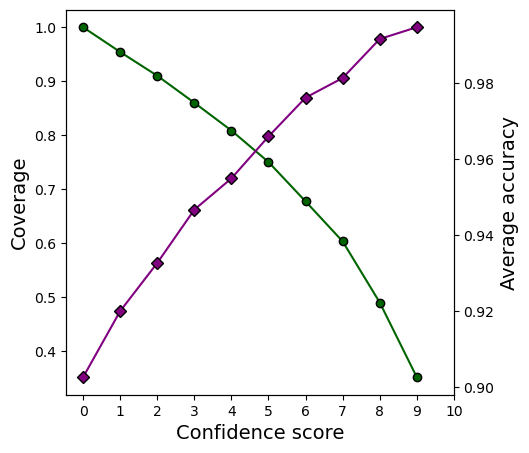

In [17]:
#plt.figure(figsize=(5, 5), dpi=150)
plot_conf_acc_cov(conf_good_df2)

In [51]:
conf_good_df1.to_pickle(os.path.join(results_dir, "good_confidence_data.pkl"))
conf_good_df2.to_pickle(os.path.join(results_dir, "good_confidence_data_sum.pkl"))

In [19]:
conf1_rand_f = os.path.join(results_dir, "rand_confidence_data.pkl")
conf2_rand_f = os.path.join(results_dir, "rand_confidence_data_sum.pkl")
if os.path.isfile(conf1_rand_f) and os.path.isfile(conf2_rand_f):
    conf_rand_df1 = pd.read_pickle(conf1_rand_f)
    conf_rand_df2 = pd.read_pickle(conf2_rand_f)
else:
    conf_rand_df1, conf_rand_df2 = get_confidences_df(ann_rand_preds, ann_rand_preds_round, ann_real_vals)

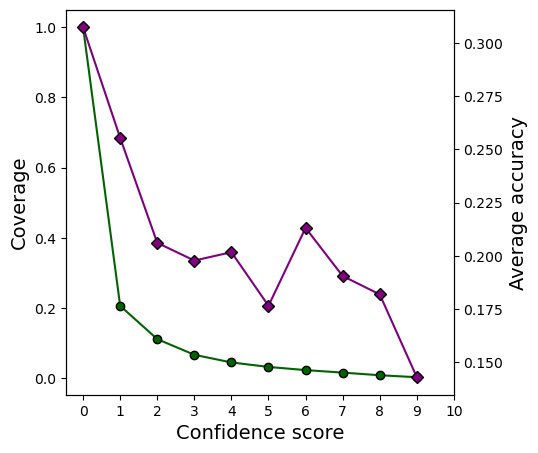

In [20]:
plot_conf_acc_cov(conf_rand_df2)

In [58]:
conf_rand_df1.to_pickle(os.path.join(results_dir, "rand_confidence_data.pkl"))
conf_rand_df2.to_pickle(os.path.join(results_dir, "rand_confidence_data_sum.pkl"))

## COMPARING CV ACCURACIES ACROSS METHODS AND BASELINES

In [21]:
print("Average 10-repeat 10-fold cross validation for KNN prediction = {}%".format(round(rskf_df.KNN_pred_acc.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for KNN random prediction = {}%".format(round(rskf_df.KNN_pred_acc_rand.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for ANN prediction = {}%".format(round(rskf_df.ANN_pred_acc.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for ANN random prediction = {}%".format(round(rskf_df.ANN_pred_acc_rand.mean()*100,2)))

print("Average 10-repeat 10-fold cross validation for random prediction = {}%".format(round(rskf_df.rand_acc.mean()*100,2)))

Average 10-repeat 10-fold cross validation for KNN prediction = 98.12%
Average 10-repeat 10-fold cross validation for KNN random prediction = 32.65%
Average 10-repeat 10-fold cross validation for ANN prediction = 90.27%
Average 10-repeat 10-fold cross validation for ANN random prediction = 30.73%
Average 10-repeat 10-fold cross validation for random prediction = 24.27%


In [22]:
ANN_pred_acc_mean = rskf_df.ANN_pred_acc.mean()
KNN_pred_acc_mean = rskf_df.KNN_pred_acc.mean()
ANN_pred_acc_rand_mean = rskf_df.ANN_pred_acc_rand.mean()
KNN_pred_acc_rand_mean = rskf_df.KNN_pred_acc_rand.mean()
rand_acc_mean = rskf_df.rand_acc.mean()

ANN_pred_acc_sem = scipy.stats.sem(rskf_df.ANN_pred_acc)
KNN_pred_acc_sem = scipy.stats.sem(rskf_df.KNN_pred_acc)
ANN_pred_acc_rand_sem = scipy.stats.sem(rskf_df.ANN_pred_acc_rand)
KNN_pred_acc_rand_sem = scipy.stats.sem(rskf_df.KNN_pred_acc_rand)
rand_acc_sem = scipy.stats.sem(rskf_df.rand_acc)

In [23]:
print("ANN ", round(ANN_pred_acc_mean*100, 2), round(ANN_pred_acc_sem*100, 2), (round((ANN_pred_acc_mean-ANN_pred_acc_sem)*100, 2), round((ANN_pred_acc_mean+ANN_pred_acc_sem)*100, 2)))

print("KNN ", round(KNN_pred_acc_mean*100, 2), round(KNN_pred_acc_sem*100, 2), (round((KNN_pred_acc_mean-KNN_pred_acc_sem)*100, 2), round((KNN_pred_acc_mean+KNN_pred_acc_sem)*100, 2)))

print("ANN_rand ", round(ANN_pred_acc_rand_mean*100, 2), round(ANN_pred_acc_rand_sem*100, 2), (round((ANN_pred_acc_rand_mean-ANN_pred_acc_rand_sem)*100, 2), round((ANN_pred_acc_rand_mean+ANN_pred_acc_rand_sem)*100, 2)))
KNN_pred_acc_rand_mean
print("KNN_rand ", round(KNN_pred_acc_rand_mean*100, 2), round(KNN_pred_acc_rand_sem*100, 2), (round((KNN_pred_acc_rand_mean-KNN_pred_acc_rand_sem)*100, 2), round((KNN_pred_acc_rand_mean+KNN_pred_acc_rand_sem)*100, 2)))

print("random ", round(rand_acc_mean*100, 2), round(rand_acc_sem*100, 2), (round((rand_acc_mean-rand_acc_sem)*100, 2), round((rand_acc_mean+rand_acc_sem)*100, 2)))

ANN  90.27 0.6 (89.67, 90.87)
KNN  98.12 0.28 (97.85, 98.4)
ANN_rand  30.73 1.08 (29.65, 31.81)
KNN_rand  32.65 0.94 (31.71, 33.59)
random  24.27 0.93 (23.34, 25.2)


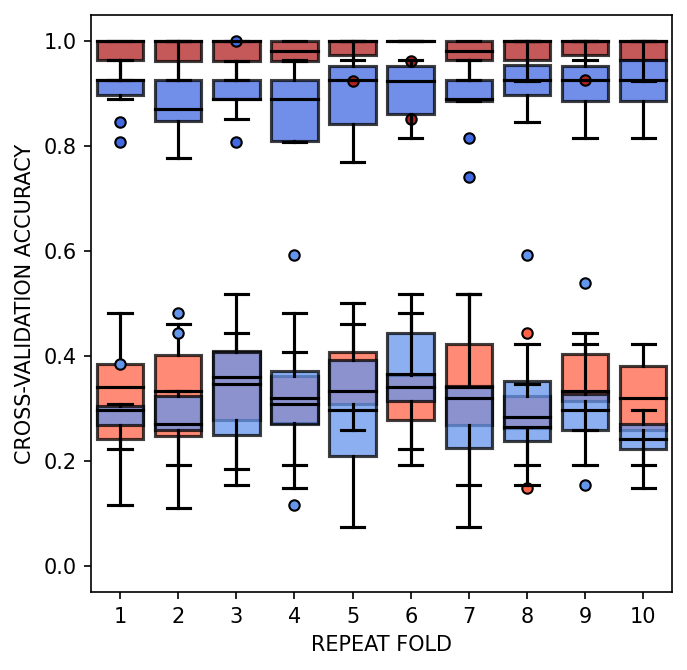

In [24]:
plt.figure(figsize=(5, 5), dpi=150)
plt.ylim(-0.05, 1.05)
ax1 = sns.boxplot(y = "KNN_pred_acc", x = "repeat_fold", data = rskf_df, color = "firebrick", **PROPS_pred_KNN, flierprops=flierprops_pred_KNN, saturation = 0.5)
sns.boxplot(y = "ANN_pred_acc", x = "repeat_fold", data = rskf_df, color = "royalblue", **PROPS_pred_ANN, flierprops=flierprops_pred_ANN, saturation = 0.5, ax = ax1)
sns.boxplot(y = "KNN_pred_acc_rand", x = "repeat_fold", data = rskf_df, color = "tomato", **PROPS_rand_KNN, flierprops=flierprops_rand_KNN, saturation = 0.5, ax = ax1)
sns.boxplot(y = "ANN_pred_acc_rand", x = "repeat_fold", data = rskf_df, color = "cornflowerblue", **PROPS_rand_ANN, flierprops=flierprops_rand_ANN, saturation = 0.5, ax = ax1)
#sns.boxplot(y = "rand_acc", x = "repeat_fold", data = rskf_df, color = "gold", **PROPS_rand, flierprops=flierprops_rand)

plt.ylabel("CROSS-VALIDATION ACCURACY")
plt.xlabel("REPEAT FOLD")
for patch in ax1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.01))
plt.show()